# Flight Delay Prediction

Data from the US department of transportation:
https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1



In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('airline_delay.csv')
data.shape

(256285, 21)

In [2]:
data.head(10)

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2003,6,AA,American Airlines Inc.,ABQ,"Albuquerque, NM: Albuquerque International Sun...",307.0,56.0,14.68,10.79,...,1.48,9.96,1.0,1.0,2530.0,510.0,621.0,676.0,25.0,698.0
1,2003,6,AA,American Airlines Inc.,ANC,"Anchorage, AK: Ted Stevens Anchorage Internati...",90.0,27.0,7.09,2.00,...,0.00,7.16,0.0,0.0,1390.0,271.0,83.0,581.0,0.0,455.0
2,2003,6,AA,American Airlines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",752.0,186.0,33.99,27.82,...,1.90,17.53,5.0,0.0,8314.0,1367.0,1722.0,3817.0,139.0,1269.0
3,2003,6,AA,American Airlines Inc.,AUS,"Austin, TX: Austin - Bergstrom International",842.0,174.0,60.24,20.54,...,4.69,40.75,9.0,1.0,8344.0,3040.0,1032.0,1835.0,115.0,2322.0
4,2003,6,AA,American Airlines Inc.,BDL,"Hartford, CT: Bradley International",383.0,55.0,14.90,8.91,...,0.00,16.61,0.0,0.0,3137.0,815.0,574.0,555.0,0.0,1193.0
5,2003,6,AA,American Airlines Inc.,BHM,"Birmingham, AL: Birmingham-Shuttlesworth Inter...",89.0,12.0,2.79,2.19,...,1.00,3.82,0.0,0.0,673.0,94.0,90.0,50.0,35.0,404.0
6,2003,6,AA,American Airlines Inc.,BNA,"Nashville, TN: Nashville International",445.0,82.0,25.44,11.98,...,0.03,26.65,2.0,0.0,4663.0,1217.0,913.0,800.0,1.0,1732.0
7,2003,6,AA,American Airlines Inc.,BOS,"Boston, MA: Logan International",1266.0,225.0,69.43,23.66,...,2.25,45.73,7.0,0.0,12139.0,4201.0,1783.0,3067.0,45.0,3043.0
8,2003,6,AA,American Airlines Inc.,BUR,"Burbank, CA: Bob Hope",119.0,27.0,7.49,4.65,...,0.00,7.04,1.0,0.0,1187.0,326.0,191.0,285.0,0.0,385.0
9,2003,6,AA,American Airlines Inc.,BWI,"Baltimore, MD: Baltimore/Washington Internatio...",593.0,101.0,17.56,20.49,...,0.00,24.69,1.0,1.0,5698.0,1058.0,1332.0,1708.0,0.0,1600.0


The First Step is cleaning data, and drop null data. 

In [3]:
pd.concat([data.isnull().sum(), 100 * data.isnull().sum()/len(data)], 
              axis=1).rename(columns={0:'Missing Data', 1:'Percentage (%)'})

,Missing Data,Percentage (%)
year,0,0.000000
month,0,0.000000
carrier,0,0.000000
carrier_name,0,0.000000
airport,0,0.000000
airport_name,0,0.000000
arr_flights,362,0.141249
arr_del15,416,0.162319
carrier_ct,362,0.141249
weather_ct,362,0.141249


In [4]:
data.dropna(inplace = True)

In [5]:
totalyear=17
totalmonth = 12
delay_causes = 7
NUM = len(data)
company_list = data['carrier'].unique()
airport_list = data['airport'].unique()


#print(NUM)
#print(airport_list) 
#print(len(airport_list))

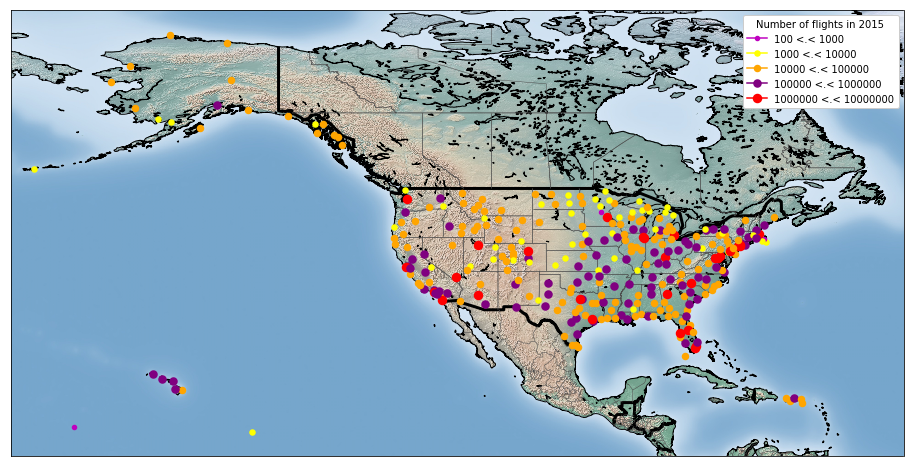

In [8]:
from collections import OrderedDict
from mpl_toolkits.basemap import Basemap

airports = pd.read_csv("airports.csv")

#count_flights = data['airport'].value_counts()
count_flights = data.groupby('airport', as_index=False).agg({'arr_flights': 'sum'})
#___________________________
plt.figure(figsize=(16,16))
#________________________________________
# define properties of markers and labels
colors = ['lightblue', 'm','yellow', 'orange', 'purple', 'red' ]
size_limits = [1, 100, 1000, 10000, 100000, 1000000, 10000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    val0 = count_flights[count_flights.airport==code].arr_flights.item()
    isize = [i for i, val in enumerate(size_limits) if val < val0]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+3, 
             markeredgewidth = 1.5, color = colors[ind], label = labels[ind])

#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('100 <.< 1000', '1000 <.< 10000'
             ,'10000 <.< 100000', '100000 <.< 1000000', '1000000 <.< 10000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
    #print(key,by_label[key])
plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':12},
           title='Number of flights from 6/2003 to 2/2015', frameon = True, framealpha = 1)
plt.show()

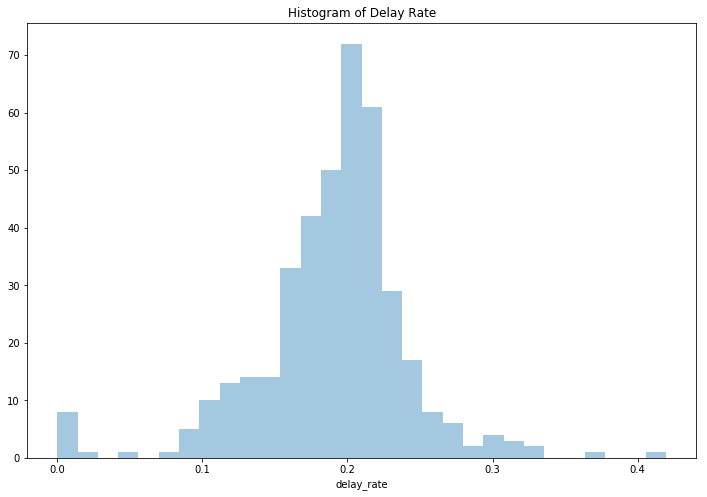

In [12]:
import numpy as np
np.set_printoptions(threshold=np.inf)

#count_flights = data.groupby('airport').agg({'arr_flights': 'sum'}).sort_values('arr_flights', ascending=False) 
#count_flights = data['airport'].value_counts()
#count_flights = data.groupby('airport', as_index=False).agg({'arr_flights': 'sum'})
#count_flights
#count_flights.loc[count_flights['airport'] == 'ABE']

#count_flights[count_flights.airport=='ABE'].airport.item()

count_delays = data.groupby('airport', as_index=False).agg({'arr_del15': 'sum'})

count_delays['delay_rate'] = count_delays['arr_del15']/count_flights['arr_flights']
count_delays = count_delays[count_delays['delay_rate'] < 1.0]
#count_delays

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.distplot(count_delays['delay_rate'],bins=30,kde=False)
ax.set_title('Histogram of Delay Rate')
plt.show()

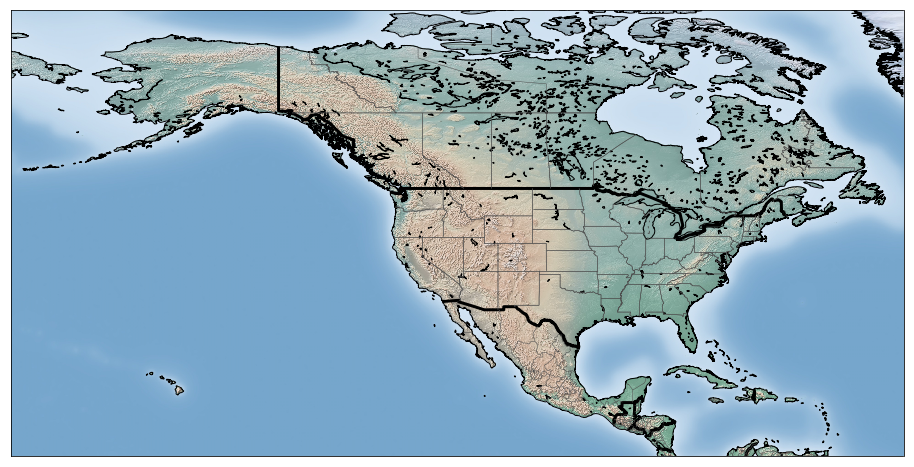

In [18]:
plt.figure(figsize=(16,16))
#________________________________________
# define properties of markers and labels
colors = ['lightblue', 'm','sandybrown','yellow', 'orange', 'purple', 'red' ]
size_limits = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5,1]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))

#labels

#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')